Using reinforcement learning to learn to play atari videogames.

In [23]:
import gym
import torch
import numpy
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms, utils, datasets
from functools import reduce

In [24]:
#The policy network in the PPO algorithm
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, end_dim):
        super(PolicyNetwork, self).__init__()
        self._net = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, end_dim),
            nn.Softmax(1)
        )
        
    def forward(self, x):
        return self._net(x)   
    
#The value network used in the PPO algorithm
class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super(ValueNetwork, self).__init__()
        self._net = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,1)
        )
        
    def forward(self, x):
        return self._net(x)

#A class for the advantage dataset
class AdvantageDataset(Dataset):
    def __init__(self, experience):                                                                                                                 
        super(AdvantageDataset, self).__init__()                                                                                                    
        self._exp = experience                                                                                                                      
        self._num_runs = len(experience)                                                                                                            
        self._length = reduce(lambda acc, x: acc + len(x), experience, 0)                                                                           
 
    def __getitem__(self, index):                                                                                                                   
        idx = 0                                                                                                                                     
        seen_data = 0                                                                                                                               
        current_exp = self._exp[0]                                                                                                                  
        while seen_data + len(current_exp) - 1 < index:                                                                                             
            seen_data += len(current_exp)                                                                                                           
            idx += 1                                                                                                                                
            current_exp = self._exp[idx]                                                                                                            
        chosen_exp = current_exp[index - seen_data]                                                                                                 
        return chosen_exp[0], chosen_exp[4]                                                                                                         
 
    def __len__(self):                                                                                                                              
        return self._length

#A class for the policy dataset
class PolicyDataset(Dataset):
    def __init__(self, experience):                                                                                                                 
        super(PolicyDataset, self).__init__()                                                                                                       
        self._exp = experience                                                                                                                      
        self._num_runs = len(experience)                                                                                                            
        self._length = reduce(lambda acc, x: acc + len(x), experience, 0)                                                                           
 
    def __getitem__(self, index):                                                                                                                   
        idx = 0                                                                                                                                     
        seen_data = 0                                                                                                                               
        current_exp = self._exp[0]                                                                                                                  
        while seen_data + len(current_exp) - 1 < index:                                                                                             
            seen_data += len(current_exp)                                                                                                           
            idx += 1                                                                                                                                
            current_exp = self._exp[idx]                                                                                                            
        chosen_exp = current_exp[index - seen_data]                                                                                                 
        return chosen_exp                                                                                                                           
 
    def __len__(self):                                                                                                                              
        return self._length  
    
def calculate_returns(rollouts, gamma):
    for roll_count, rollout in enumerate(rollouts):
        prev = 0
        rollout.reverse()
        for counter, i in enumerate(rollout):
            my_rew = i[3]
            prev  = my_rew + prev*gamma
            rollout[counter] = (i[0],i[1],i[2],i[3],prev)
        rollout.reverse()
        rollouts[roll_count] = rollout
    return(rollouts)
    
#The function for learning to play the game  
def RLL(env, state_num, epoch_num, learn_rate):
    env = gym.make(env)
    policy = PolicyNetwork(state_num,2)
    value = ValueNetwork(state_num)
    policy_optim = optim.Adam(policy.parameters(), lr=learn_rate)#, weight_decay=0.01)
    value_optim = optim.Adam(value.parameters(), lr=learn_rate)#, weight_decay=1)
    value_loss = torch.nn.MSELoss()

    # ... more stuff here...

    epochs = epoch_num
    env_samples = 100
    episode_length = 200
    gamma = 0.9
    value_epochs = 2
    policy_epochs = 5
    batch_size = 32
    policy_batch_size = 256
    epsilon = 0.2
    reward_vec = []
    return_vec = []
    standing_len_vec = []

    for num in range(epochs):
        rollouts = []
        standing_len = 0
        my_reward = 0
        my_return = 0
        for roll_ep in range(env_samples):
            current_rollout = []
            s = env.reset()
            for i in range(episode_length):
                action = policy(torch.from_numpy(s).float().view(1,-1))  
                idx = np.random.multinomial(1, action.detach().numpy().reshape((2)))
                idx = np.argmax(idx)
                new_state, reward, end, _ = env.step(idx)
                current_rollout.append((s, action.detach().reshape(-1), idx, reward))
                standing_len+=1
                s = new_state
                if end == True:
                    break
            rollouts.append(current_rollout)

        #print('avg standing time:', standing_len / env_samples)
        standing_len_vec.append(standing_len / env_samples)
        calculate_returns(rollouts, gamma)

        # Approximate the value function
        value_dataset = AdvantageDataset(rollouts)
        value_loader = DataLoader(value_dataset, batch_size=batch_size, shuffle=True, pin_memory=True,drop_last=True)
        for value_ep in range(value_epochs):
            # train value 
            total_val_loss = 0
            for state, ret in value_loader:
                value_optim.zero_grad()
                ret = ret.unsqueeze(1).float()
                expected_ret = value(state.float())
                loss = value_loss(expected_ret, ret)
                loss.backward()
                value_optim.step()
                total_val_loss += loss.item()
            #value_losses.append(total_val_loss)
            #print('Total Value Loss: ', total_val_loss)

        # Learn a policy
        policy_dataset = PolicyDataset(rollouts)
        policy_loader = DataLoader(policy_dataset, batch_size=policy_batch_size, shuffle=True, pin_memory=True,drop_last=True)
        for poll_ep in range(policy_epochs):
            # train policy network
            total_pol_loss = 0
            for state, action, idx, reward, ret in policy_loader:
                policy_optim.zero_grad()
                my_val = value(state.float()).float().detach()
                advantage = ret.float().unsqueeze(0)-my_val
                old_prob = action[range(state.size()[0]),idx]
                new_prob = policy(state.float())[range(state.size()[0]),idx]
                ratio = new_prob/old_prob
                left = ratio*advantage
                right = torch.clamp(ratio, 1-epsilon, 1+epsilon)*advantage
                loss = -torch.mean(torch.min(left, right))
                loss.backward()
                policy_optim.step()
                total_pol_loss+=loss
                my_return+=torch.sum(ret)
                my_reward+=reward.mean().item()
            total_pol_loss = total_pol_loss.mean()
            #policy_losses.append(total_pol_loss)
            #print('Total Policy Loss: ', total_pol_loss.item())
        reward_vec.append(my_reward/policy_epochs)
        return_vec.append(my_return/policy_epochs)
        print('Epoch ' + str(num+1))
    return(standing_len_vec, reward_vec, return_vec)

## Cart-Pole Standing-Time Results

In [31]:
standing_len_vec, reward_vec, return_vec = RLL('CartPole-v0', 4,100,1e-4)

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100


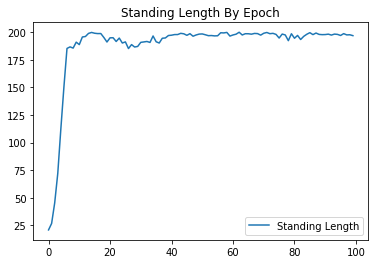

In [32]:
plt.plot(standing_len_vec, label='Standing Length')
plt.title("Standing Length By Epoch")
plt.legend()
plt.show()

## Centipede Run Rewards Results

In [27]:
#Trying on a different game
standing_len_vec, reward_vec, return_vec = RLL('Centipede-ram-v0', 128,200, 1e-4)

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epoch 106
Epoch 107
Epoch 108
Epoch 109
Epoch 110
Epoch 11

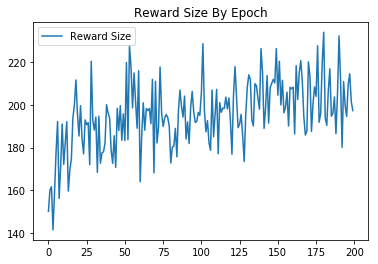

In [30]:
#The rewards
plt.plot(reward_vec, label='Reward Size')
plt.title("Reward Size By Epoch")
plt.legend()
plt.show()